In [1]:
# University of Toronto
# Faculty of Information
# INF2178 
# Chi-shiun Yang 
# 1009916897 
# Mar 03, 2024 
# Assignment 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from statsmodels.graphics.factorplots import interaction_plot


# load data
df = pd.read_excel('INF2178_A2_data.xlsx')
df.head()

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,Y
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,Y
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,Y
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,15,40,0,0,65,Y,Y
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,10,16,0,0,26,Y,Y


In [2]:
# add new columns to the dataframe
# the new columns are the original value in the age group divided by total space
df["IG_rate"] = df["IGSPACE"] / df["TOTSPACE"]
df["TG_rate"] = df["TGSPACE"] / df["TOTSPACE"]
df["PG_rate"] = df["PGSPACE"] / df["TOTSPACE"]
df["KG_rate"] = df["KGSPACE"] / df["TOTSPACE"]
df["SG_rate"] = df["SGSPACE"] / df["TOTSPACE"]

df.head()

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,...,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag,IG_rate,TG_rate,PG_rate,KG_rate,SG_rate
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,...,52,60,164,Y,Y,0.000000,0.121951,0.195122,0.317073,0.365854
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,...,26,45,83,Y,Y,0.000000,0.000000,0.144578,0.313253,0.542169
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,...,26,50,102,Y,Y,0.000000,0.098039,0.156863,0.254902,0.490196
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,...,0,0,65,Y,Y,0.153846,0.230769,0.615385,0.000000,0.000000
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,...,0,0,26,Y,Y,0.000000,0.384615,0.615385,0.000000,0.000000


In [3]:
# the function for running the one-way ANOVA
# the function takes the name of two columns 
def one_way_anova(category_col, value_col):
    # draw the box plot of these two columns
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x = category_col, y = value_col, data = df, color='#99c2a2')
    plt.show()

    # string for using in models
    model_str = value_col + ' ~ C(' + category_col + ')'

    # Ordinary Least Squares (OLS) model
    model = ols(model_str, data = df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA table")
    display(anova_table)

    # ANOVA table
    res = stat()
    res.anova_stat(df = df, res_var = value_col, anova_model = model_str)
    print("\nANOVA summary")
    display(res.anova_summary)

    # if the p-value is less than 0.05
    if res.anova_summary["PR(>F)"][0] < 0.05:
        print("The p-value is less than 0.05, we reject the null hypothesis.")
        # we apply a post hoc test using Tukey's HSD
        res.tukey_hsd(df = df, res_var = value_col, xfac_var = category_col, anova_model = model_str)
        print("\nTukey summary")
        display(res.tukey_summary)

    # checking assumtions
    # assumption 1: res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    sm.qqplot(res.anova_std_residuals, line='45')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.show()

    # histogram
    plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
    plt.xlabel("Residuals")
    plt.ylabel('Frequency')
    plt.show()

    # assumption 1: residuals are normally distributed: Shapiro Wilk test
    w, pvalue = stats.shapiro(model.resid)
    print("Shapiro Wilk test results: ")
    print(w, pvalue)

    #assumption 2: variances are homoegenous
    if pvalue > 0.05:
        # Bartlett's test when the sample is normally distributed
        res = stat()
        res.bartlett(df = df, res_var = value_col, xfac_var= category_col)
        print("\nThe sample is normally distributed, Bartlett's test results: ")
        display(res.bartlett_summary)
    else:
        # Levene's test when the sample is not normally distributed
        res.levene(df = df, res_var = value_col, xfac_var= category_col)
        print("\nThe sample is not normally distributed, Levene's test results: ")
        display(res.levene_summary)



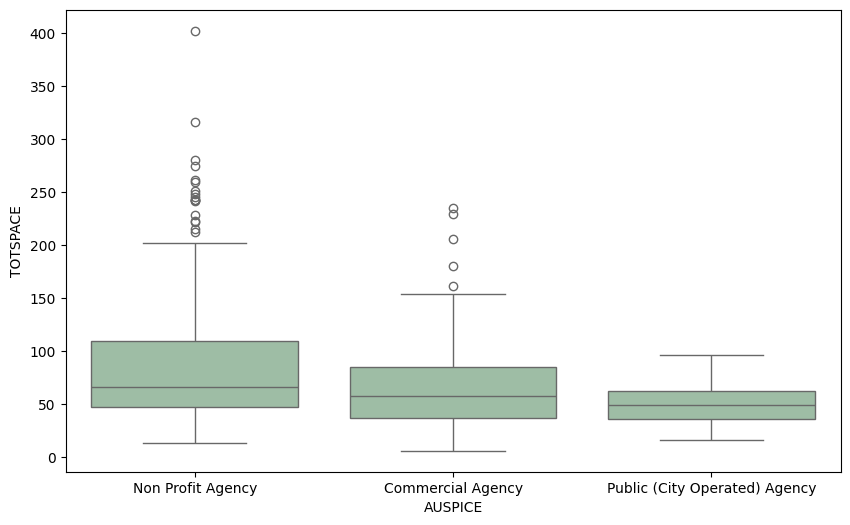

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),9.611211e+04,2.0,21.843051,5.057716e-10
Residual,2.332065e+06,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,9.611211e+04,48056.057145,21.843051,5.057716e-10
Residual,1060.0,2.332065e+06,2200.061571,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,16.806538,3.993722,29.619353,4.356853,0.006071
1,Non Profit Agency,Public (City Operated) Agency,36.177966,8.673910,63.682022,4.369046,0.005901
2,Commercial Agency,Public (City Operated) Agency,19.371429,-10.141900,48.884757,2.180132,0.272554


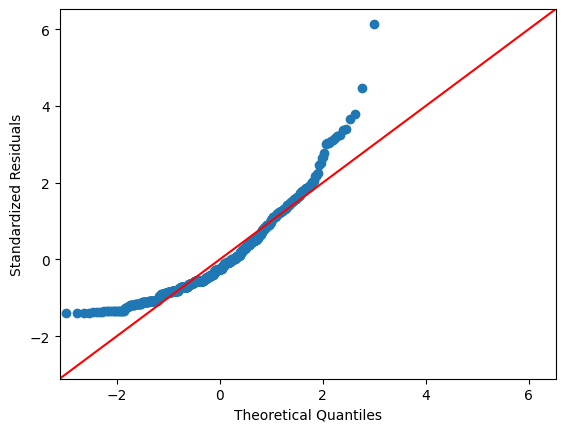

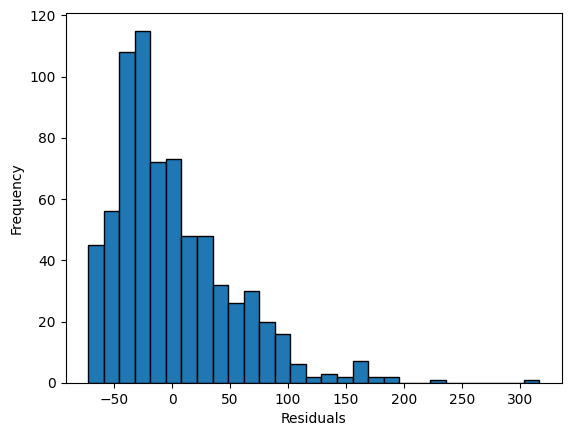

Shapiro Wilk test results: 
0.901775598526001 1.4964898448030214e-25

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),9.1994
1,Degrees of freedom (Df),2.0000
2,p value,0.0001


In [4]:
# Research question 1
one_way_anova("AUSPICE", "TOTSPACE")

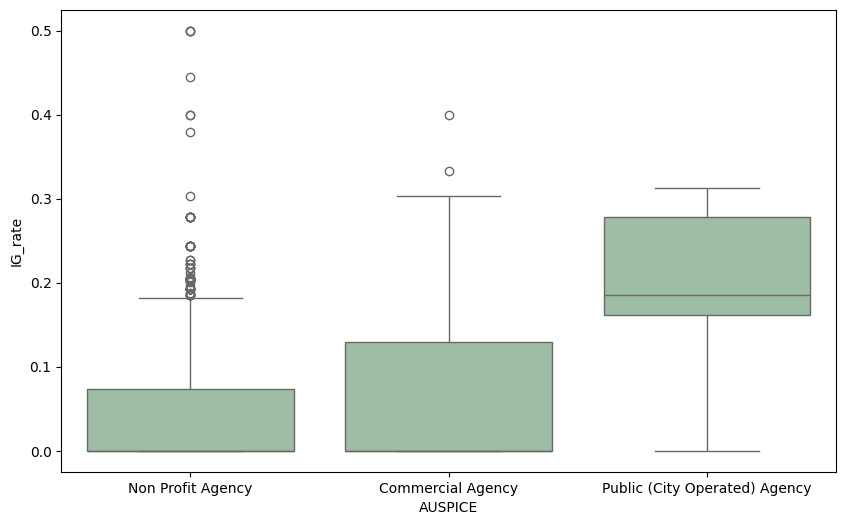

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),0.713553,2.0,46.802956,3.323900e-20
Residual,8.080323,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,0.713553,0.356776,46.802956,3.323900e-20
Residual,1060.0,8.080323,0.007623,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,0.002014,-0.016962,0.020989,0.352491,0.900
1,Non Profit Agency,Public (City Operated) Agency,0.142506,0.101773,0.183240,11.620479,0.001
2,Commercial Agency,Public (City Operated) Agency,0.140493,0.096784,0.184202,10.676326,0.001


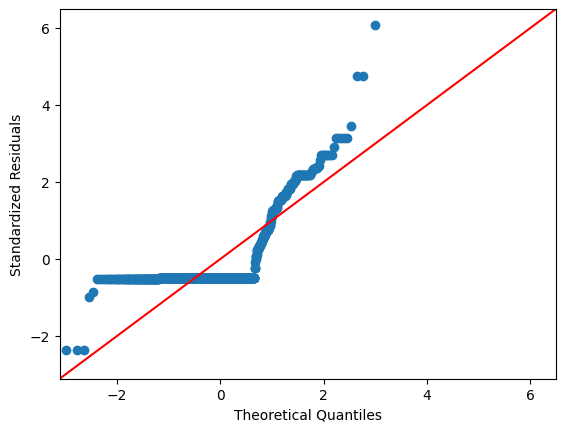

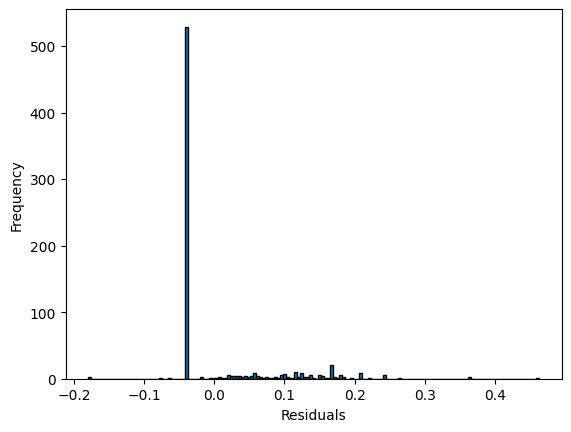

Shapiro Wilk test results: 
0.7406561970710754 9.043095228642302e-38

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),2.1303
1,Degrees of freedom (Df),2.0000
2,p value,0.1196


In [5]:
# Research question 2 - IG_rate
one_way_anova("AUSPICE", "IG_rate")

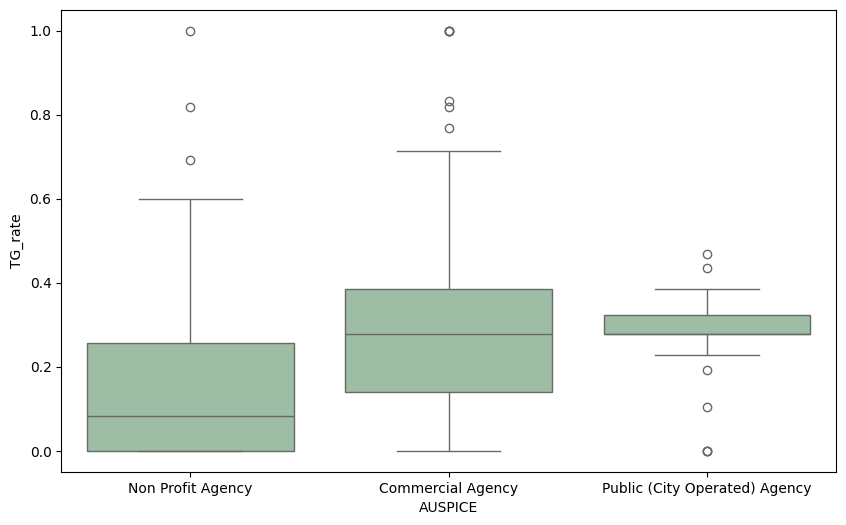

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),4.358882,2.0,78.267943,1.976508e-32
Residual,29.516651,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,4.358882,2.179441,78.267943,1.976508e-32
Residual,1060.0,29.516651,0.027846,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,0.101487,0.064429,0.138546,9.096280,0.001000
1,Non Profit Agency,Public (City Operated) Agency,0.160081,0.080531,0.239630,6.684044,0.001000
2,Commercial Agency,Public (City Operated) Agency,0.058593,-0.026768,0.143955,2.279966,0.241366


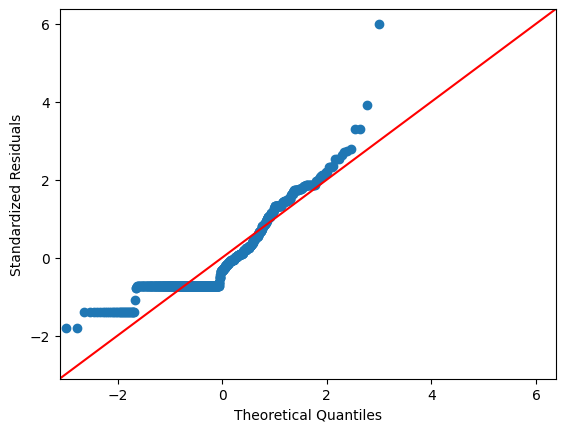

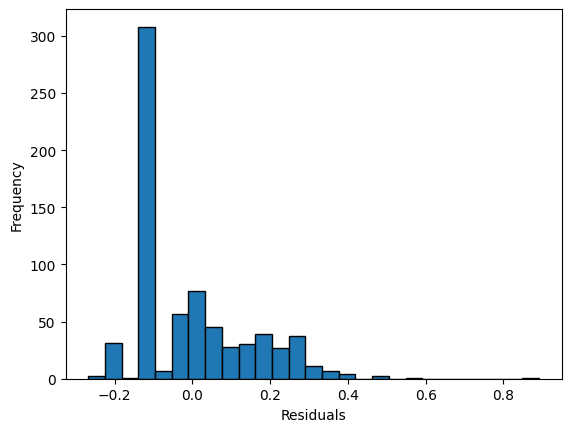

Shapiro Wilk test results: 
0.921040952205658 3.7841727043211596e-23

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),4.5100
1,Degrees of freedom (Df),2.0000
2,p value,0.0113


In [6]:
# Research question 2 - TG_rate
one_way_anova("AUSPICE", "TG_rate")

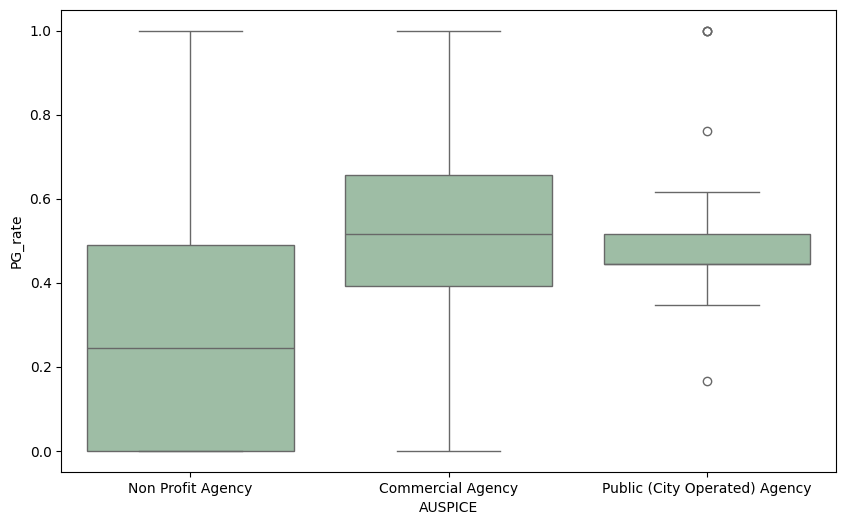

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),12.758888,2.0,89.38639,1.338234e-36
Residual,75.651454,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,12.758888,6.379444,89.38639,1.338234e-36
Residual,1060.0,75.651454,0.071369,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,0.312115,0.246508,0.377721,15.801816,0.001000
1,Non Profit Agency,Public (City Operated) Agency,0.243057,0.102226,0.383888,5.732554,0.001000
2,Commercial Agency,Public (City Operated) Agency,0.069058,-0.082061,0.220177,1.517866,0.529811


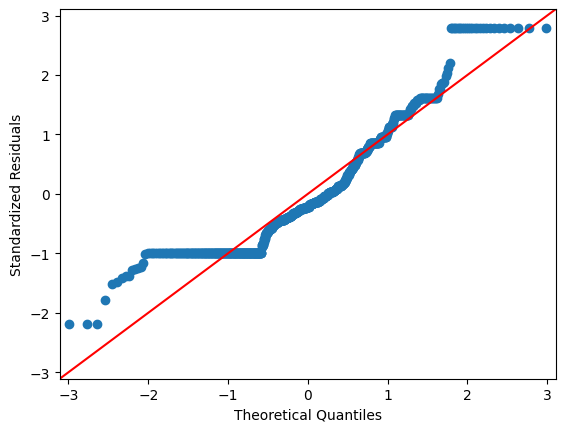

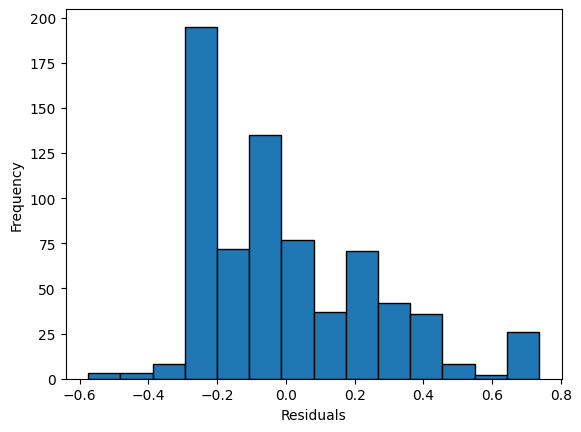

Shapiro Wilk test results: 
0.9466361403465271 3.7445380655721587e-19

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),2.6146
1,Degrees of freedom (Df),2.0000
2,p value,0.0739


In [7]:
# Research question 2 - PG_rate
one_way_anova("AUSPICE", "PG_rate")

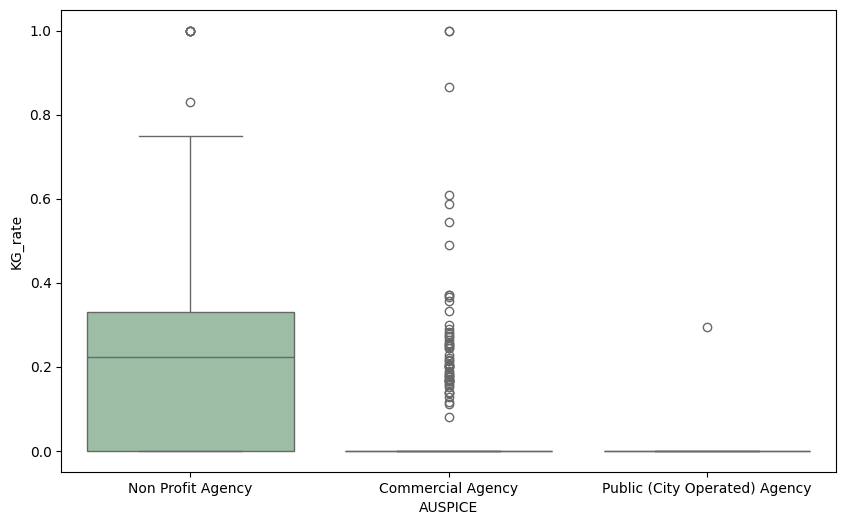

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),5.519674,2.0,90.582842,4.812116e-37
Residual,32.295601,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,5.519674,2.759837,90.582842,4.812116e-37
Residual,1060.0,32.295601,0.030468,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,0.165733,0.121018,0.210448,12.311011,0.001000
1,Non Profit Agency,Public (City Operated) Agency,0.208785,0.112799,0.304771,7.224907,0.001000
2,Commercial Agency,Public (City Operated) Agency,0.043052,-0.059946,0.146050,1.388374,0.582199


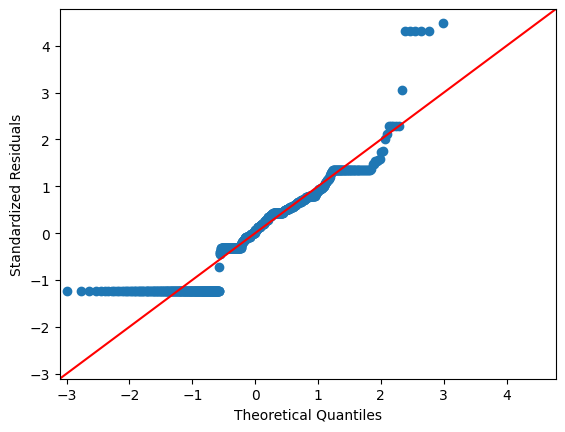

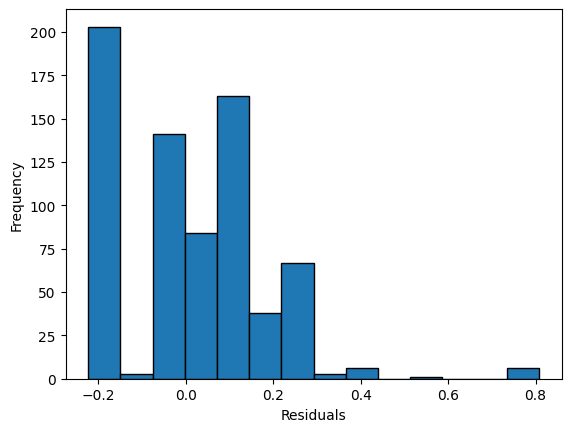

Shapiro Wilk test results: 
0.8782628774642944 4.895655659251536e-28

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),41.519
1,Degrees of freedom (Df),2.000
2,p value,0.000


In [8]:
# Research question 2 - KG_rate
one_way_anova("AUSPICE", "KG_rate")

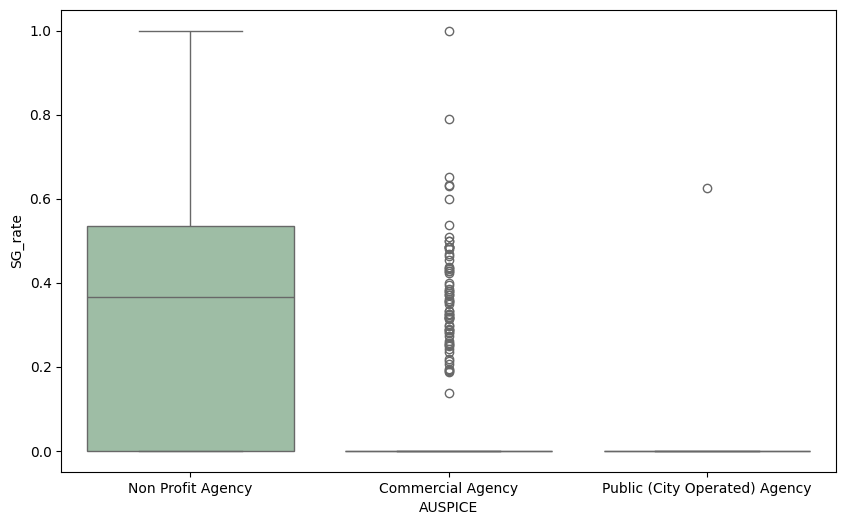

ANOVA table


,sum_sq,df,F,PR(>F)
C(AUSPICE),14.428900,2.0,107.676247,2.679685e-43
Residual,71.021393,1060.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,14.428900,7.214450,107.676247,2.679685e-43
Residual,1060.0,71.021393,0.067001,NaN,NaN


The p-value is less than 0.05, we reject the null hypothesis.

Tukey summary


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,0.249883,0.181514,0.318252,12.139973,0.001000
1,Non Profit Agency,Public (City Operated) Agency,0.336859,0.190098,0.483620,7.623894,0.001000
2,Commercial Agency,Public (City Operated) Agency,0.086976,-0.070506,0.244458,1.834451,0.398791


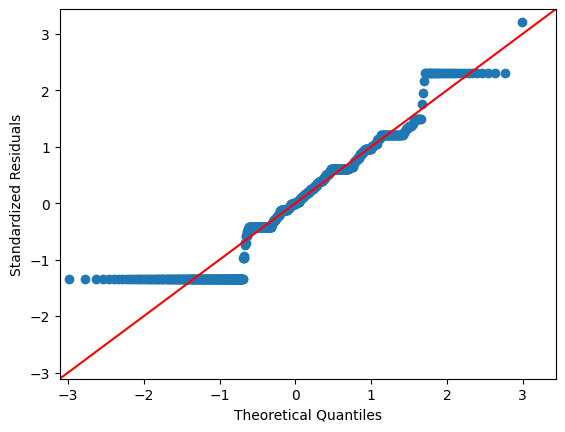

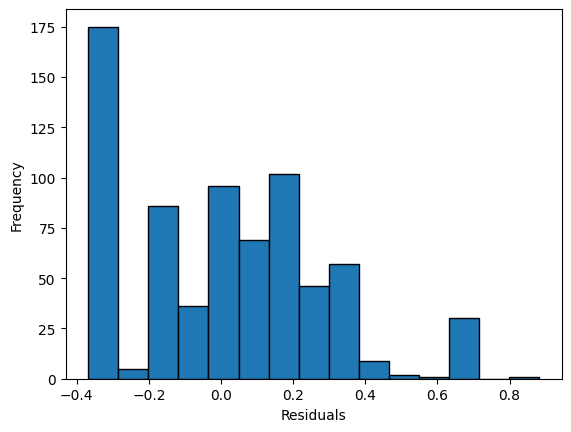

Shapiro Wilk test results: 
0.9172824025154114 1.1933004249969619e-23

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),33.525
1,Degrees of freedom (Df),2.000
2,p value,0.000


In [9]:
# Research question 2 - SG_rate
one_way_anova("AUSPICE", "SG_rate")

In [10]:
# the function for running the two-way ANOVA
# the function takes the name of three columns 
def two_way_anova(category_col_1, category_col_2, value_col):
    # draw the box plot of these columns
    sns.boxplot(x= category_col_1, y = value_col, hue = category_col_2, data = df, palette = "Set3")
    plt.show()

    # string for using in models
    model_str = value_col + ' ~ C(' + category_col_1 + ') + C(' + category_col_2 + ') + C(' + category_col_1 + '):C(' + category_col_2 + ')'

    # Ordinary Least Squares (OLS) model
    model=ols(model_str, data = df).fit()
    anova_table = sm.stats.anova_lm(model, typ = 2)
    print("ANOVA table")
    display(anova_table)

    # ANOVA table
    res = stat()
    res.anova_stat(df = df, res_var = value_col, anova_model = model_str)
    print("\nANOVA summary")
    display(res.anova_summary)

    # Interaction Plot
    fig = interaction_plot(x = df[category_col_1], trace = df[category_col_2],response = df[value_col], colors = ['#4c061d', '#d17a22'])
    plt.show()

    # if the p-value is less than 0.05
    if res.anova_summary["PR(>F)"][0] < 0.05 and res.anova_summary["PR(>F)"][1] < 0.05 and res.anova_summary["PR(>F)"][2] < 0.05:
        print("The p-value are less than 0.05, we reject the null hypothesis.")
        # we apply post hoc tests using Tukey's HSD
        res.tukey_hsd(df = df, res_var = value_col, xfac_var = category_col_1, anova_model = model_str)
        print("\nTukey summary of column " + category_col_1)
        display(res.tukey_summary)
        
        res.tukey_hsd(df = df, res_var = value_col, xfac_var = category_col_2, anova_model = model_str)
        print("\nTukey summary of column " + category_col_2)
        display(res.tukey_summary)

        res.tukey_hsd(df = df,res_var = value_col, xfac_var = [category_col_1, category_col_2], anova_model = model_str)
        display(res.tukey_summary)


    # checking assumtions
    # assumption 1: res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    sm.qqplot(res.anova_std_residuals, line='45')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.show()

    # histogram
    plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
    plt.xlabel("Residuals")
    plt.ylabel('Frequency')
    plt.show()

    # assumption 1: residuals are normally distributed: Shapiro Wilk test
    w, pvalue = stats.shapiro(model.resid)
    print("Shapiro Wilk test results: ")
    print(w, pvalue)

    #assumption 2: variances are homoegenous
    if pvalue > 0.05:
        # Bartlett's test when the sample is normally distributed
        res = stat()
        res.bartlett(df = df, res_var = value_col, xfac_var = [category_col_1, category_col_2])
        print("\nThe sample is normally distributed, Bartlett's test results: ")
        display(res.bartlett_summary)
    else:
        # Levene's test when the sample is not normally distributed
        res.levene(df = df, res_var = value_col, xfac_var = [category_col_1, category_col_2])
        print("\nThe sample is not normally distributed, Levene's test results: ")
        display(res.levene_summary)




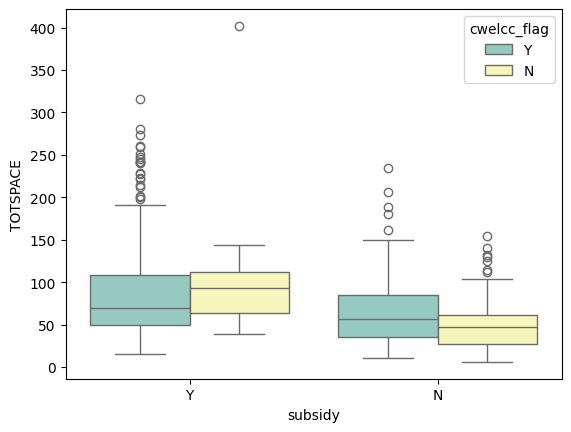

ANOVA table


,sum_sq,df,F,PR(>F)
C(subsidy),9.816181e+04,1.0,46.375040,1.633653e-11
C(cwelcc_flag),6.723429e+03,1.0,3.176381,7.499648e-02
C(subsidy):C(cwelcc_flag),1.910868e+04,1.0,9.027604,2.721895e-03
Residual,2.241580e+06,1059.0,NaN,NaN



ANOVA summary


,df,sum_sq,mean_sq,F,PR(>F)
C(subsidy),1.0,9.816181e+04,98161.809243,46.375040,1.633653e-11
C(cwelcc_flag),1.0,6.723429e+03,6723.428955,3.176381,7.499648e-02
C(subsidy):C(cwelcc_flag),1.0,1.910868e+04,19108.682949,9.027604,2.721895e-03
Residual,1059.0,2.241580e+06,2116.694877,NaN,NaN


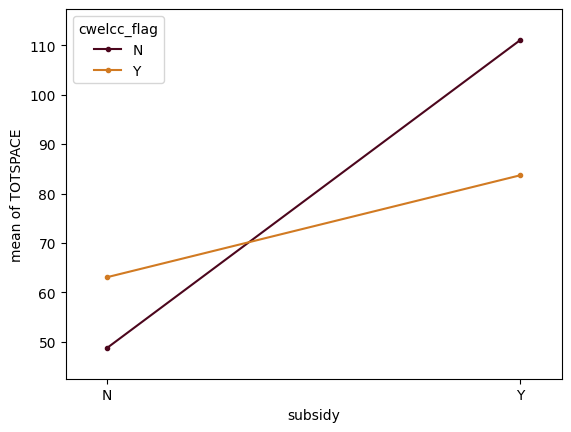

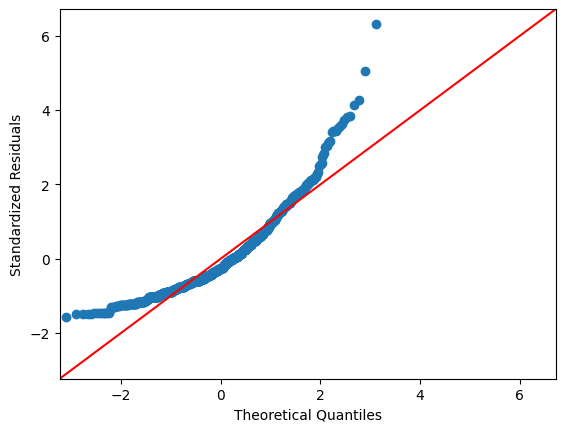

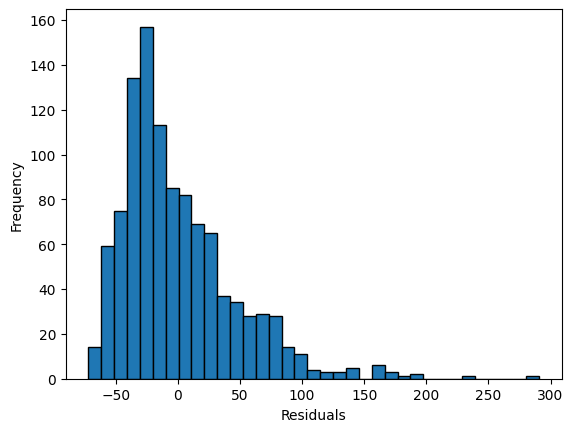

Shapiro Wilk test results: 
0.8959829211235046 3.337903758624965e-26

The sample is not normally distributed, Levene's test results: 


,Parameter,Value
0,Test statistics (W),7.3853
1,Degrees of freedom (Df),3.0000
2,p value,0.0001


In [11]:
# Research question 3
two_way_anova('subsidy', 'cwelcc_flag', 'TOTSPACE')